In this analysis, we shall attempt to find out if championship teams have a certain winning formula that can be found through k-means clustering. The hypothesis is that if championship teams have something special in their stats, either through sheer dominance across the stat board or a certain niche, it would show in the clusters. 

In [1]:
from lxml import html
import requests
from bs4 import  BeautifulSoup
from bs4 import Comment
from time import sleep
from selenium import webdriver
import pandas as pd
from sklearn.cluster import KMeans       
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

In [2]:
def parse(url,driver):
    driver.get(url)
    sleep(3)
    sourceCode=driver.page_source
    return  sourceCode

In [3]:
#url = 'https://www.basketball-reference.com/leagues/NBA_{}.html'.format(year)
#url = 'https://www.basketball-reference.com/leagues/NBA_2020.html'

In [4]:
def get_league_yearly_data(url,driver):
        soup = BeautifulSoup(parse(url,driver),'lxml')
        table_entry = soup.find('table',id = "team-stats-per_game")
        table = table_entry.find_all('tr', limit =2 )
        headers = [th.getText() for th in table[0].find_all('th')]
        headers = headers[1:]
        rows = table_entry.find_all('tr')[1:]
        player_stats = [[td.getText() for td in rows[i].find_all('td')]for i in range(len(rows))]
        df = pd.DataFrame(player_stats, columns = headers)
        temp_df = df.dropna()
        df_cleaned = temp_df.drop(temp_df.index[-1])
        return df_cleaned

In [5]:
league_avg_dict = {}
driver = webdriver.Firefox(executable_path =r'C:\Users\User\Desktop\Basketball\geckodriver')
for i in range(1997,2021):
    year = i
    url = 'https://www.basketball-reference.com/leagues/NBA_{}.html'.format(year)
    league_avg_dict[str(year)] = get_league_yearly_data(url,driver)

driver.close

len(league_avg_dict)


24

In [75]:
#league_avg_dict['2020'].info()

In [7]:
copy = league_avg_dict.copy()

In [8]:
col = list(copy['1997'].columns)
#col

In [9]:
col.remove('Team')
col.remove('G')
col.remove('MP')
#col

In [10]:
for season, df in copy.items():
    copy[season] = df[col].apply(pd.to_numeric, errors='coerce')

In [11]:
league_avg_dict_numeric = copy.copy()

In [12]:
league_avg_list = [df for df in league_avg_dict.values()]
league_avg_numeric_list = [df for df in league_avg_dict_numeric.values()]

In [13]:
key_list = [i for i in range(1997,2021)]

In [14]:
league_avg_df = pd.concat(league_avg_list,keys = key_list)
league_avg_numeric_df = pd.concat(league_avg_numeric_list,keys = key_list)

In [15]:
X_std = StandardScaler().fit_transform(league_avg_numeric_df)

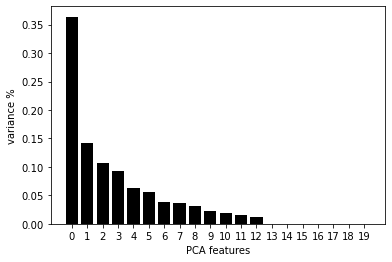

In [16]:
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X_std)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
PCA_components = pd.DataFrame(principalComponents)

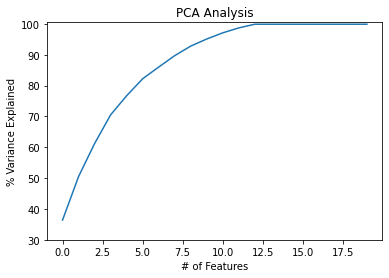

In [17]:
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')

plt.plot(var)

Text(0.5, 1.0, 'Elbow curve')

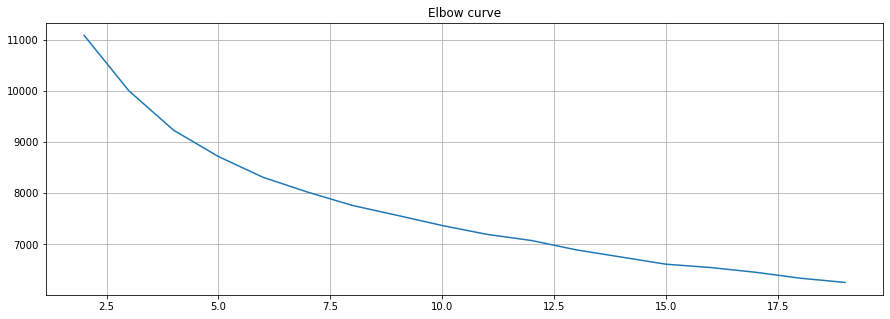

In [18]:
x= PCA_components.copy()
distortions = []
for k in range(2,20):
    kmeans = KMeans(n_clusters=k)    
    kmeans.fit(x.iloc[:,:12])                    
    distortions.append(kmeans.inertia_)   

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distortions)
plt.grid(True)
plt.title('Elbow curve')

In [19]:
k = 14

model = KMeans(n_clusters=k, random_state=0)

league_avg_kmeans = model.fit(league_avg_numeric_df)

print(league_avg_kmeans)

KMeans(n_clusters=14, random_state=0)


In [20]:
league_avg_df['label'] = league_avg_kmeans.labels_
league_avg_df.head()

Team   G     MP    FG   FGA   FG%   3P   3PA   3P%  \
1997 0        Chicago Bulls*  82  240.6  40.0  84.4  .473  6.4  17.1  .373   
     1            Utah Jazz*  82  241.8  38.2  75.8  .504  4.1  11.0  .370   
     2         Phoenix Suns*  82  242.1  38.3  81.8  .469  6.4  17.4  .369   
     3  Seattle SuperSonics*  82  241.2  36.5  78.2  .467  6.8  19.3  .353   
     4        Boston Celtics  82  242.7  37.4  85.0  .440  5.7  16.2  .351   

          2P  ...   ORB   DRB   TRB   AST   STL  BLK   TOV    PF    PTS label  
1997 0  33.6  ...  15.1  30.0  45.1  26.1   8.7  4.0  13.5  19.7  103.1     9  
     1  34.1  ...  10.8  29.4  40.2  26.8   9.1  5.1  15.4  24.2  103.1    11  
     2  31.9  ...  11.2  29.0  40.1  25.2   8.1  3.9  14.4  21.1  102.8    11  
     3  29.7  ...  12.3  27.7  40.0  23.5  11.0  4.7  15.0  22.0  100.9     6  
     4  31.7  ...  13.4  26.7  40.0  21.9   9.9  3.8  16.4  23.4  100.6     0  

[5 rows x 25 columns]

In [21]:
centroids_df = pd.DataFrame(league_avg_kmeans.cluster_centers_,columns = col)

centroids_df['label'] = centroids_df.index

centroids_df

,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,label
0,36.752941,81.814706,0.449485,5.244118,14.900000,0.351603,31.526471,66.907353,0.471235,17.694118,...,12.019118,29.741176,41.754412,21.908824,7.875000,4.970588,14.580882,21.620588,96.450000,0
1,40.528571,88.471429,0.458238,13.580952,38.019048,0.357857,26.928571,50.461905,0.534571,18.476190,...,9.990476,35.485714,45.471429,24.185714,7.495238,4.857143,14.828571,20.880952,113.100000,1
2,39.329577,85.453521,0.460380,8.659155,24.004225,0.361310,30.661972,61.445070,0.499254,17.992958,...,10.688732,32.742254,43.426761,22.832394,7.787324,4.819718,14.225352,20.407042,105.314085,2
3,33.961765,76.438235,0.444294,6.194118,17.479412,0.354706,27.761765,58.952941,0.471088,18.576471,...,10.800000,29.500000,40.285294,20.464706,7.732353,4.700000,14.791176,21.785294,92.705882,3
4,37.013462,83.228846,0.444846,3.911538,11.601923,0.336827,33.103846,71.613462,0.462250,18.576923,...,13.467308,29.986538,43.457692,22.061538,8.092308,5.238462,15.211538,22.688462,96.513462,4
5,36.246512,80.367442,0.451465,8.746512,24.200000,0.361674,27.516279,56.169767,0.490000,17.713953,...,10.458140,31.104651,41.560465,20.953488,7.681395,4.644186,14.400000,20.518605,98.967442,5
6,36.359155,79.801408,0.455887,6.547887,18.094366,0.361845,29.814085,61.707042,0.483437,19.400000,...,11.281690,30.088732,41.370423,21.169014,7.408451,4.709859,14.730986,21.801408,98.673239,6
7,41.929730,89.151351,0.470595,11.297297,30.927027,0.365622,30.637838,58.213514,0.526541,17.635135,...,10.300000,35.056757,45.340541,25.708108,7.786486,5.291892,14.197297,20.643243,112.813514,7
8,35.149123,77.705263,0.452491,3.878947,11.205263,0.345246,31.271930,66.500000,0.470333,20.692982,...,12.161404,29.615789,41.780702,21.363158,7.735088,5.247368,15.417544,22.431579,94.859649,8
9,38.476786,84.530357,0.455375,6.760714,18.798214,0.359804,31.735714,65.746429,0.482750,17.451786,...,11.798214,31.503571,43.296429,22.546429,7.853571,4.980357,13.926786,20.423214,101.183929,9


In [71]:
centroids_rank_df = pd.DataFrame()
centroids_rank_df[col] = centroids_df[col].rank(ascending = False)

centroids_rank_df

,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,8.0,7.0,10.0,11.0,11.0,11.0,4.0,2.0,10.0,9.0,...,9.0,3.0,11.0,10.0,8.0,3.0,7.0,8.0,7.0,10.0
1,2.0,2.0,4.0,1.0,1.0,6.0,14.0,14.0,1.0,6.0,...,3.0,13.0,1.0,1.0,2.0,12.0,8.0,5.0,8.0,1.0
2,3.0,4.0,3.0,5.0,5.0,4.0,6.0,9.0,4.0,7.0,...,2.0,10.0,4.0,4.0,3.0,5.0,9.0,11.0,12.0,3.0
3,14.0,14.0,13.0,9.0,9.0,9.0,12.0,10.0,11.0,5.0,...,10.0,9.0,13.0,14.0,13.0,8.0,12.0,6.0,5.0,13.0
4,7.0,6.0,12.0,13.0,13.0,14.0,1.0,1.0,13.0,4.0,...,14.0,1.0,10.0,3.0,7.0,1.0,3.0,3.0,1.0,9.0
5,11.0,10.0,9.0,4.0,4.0,3.0,13.0,12.0,6.0,8.0,...,12.0,11.0,6.0,11.0,12.0,10.0,13.0,9.0,10.0,7.0
6,10.0,11.0,5.0,8.0,8.0,2.0,8.0,8.0,7.0,3.0,...,8.0,7.0,9.0,12.0,11.0,13.0,11.0,7.0,4.0,8.0
7,1.0,1.0,1.0,2.0,2.0,1.0,7.0,11.0,2.0,10.0,...,1.0,12.0,2.0,2.0,1.0,6.0,1.0,12.0,9.0,2.0
8,12.0,13.0,7.0,14.0,14.0,12.0,5.0,3.0,12.0,2.0,...,11.0,2.0,12.0,9.0,9.0,7.0,2.0,1.0,2.0,12.0
9,5.0,5.0,6.0,7.0,7.0,5.0,3.0,4.0,8.0,11.0,...,5.0,4.0,5.0,6.0,5.0,4.0,5.0,14.0,11.0,6.0


In [ ]:
# championship_teams_list = ['CHI','CHI','SAS','LAL','LAL','LAL','SAS','DET','SAS','MIA','SAS','BOS','LAL','LAL','DAL','MIA','MIA','SAS','GSW','CLE','GSW','GSW','TOR','LAL']
# #len(championship_teams_list)
# championship_teams_dict = {team : year for team,year in enumerate(championship_teams_list,start = 1997)}
# championship_teams_dict

In [59]:
championship_teams_df = pd.read_csv('ChampionshipTeams.csv', names = ['year', 'team'])
championship_teams_df = championship_teams_df.iloc[::-1].reset_index(drop = True)
championship_teams_series = championship_teams_df['team']
championship_teams_dict = {year: (team+"*") for year,team in enumerate(list(championship_teams_series),start = 1997)}
championship_teams_dict

{1997: 'Chicago Bulls*',
 1998: 'Chicago Bulls*',
 1999: 'San Antonio Spurs*',
 2000: 'Los Angeles Lakers*',
 2001: 'Los Angeles Lakers*',
 2002: 'Los Angeles Lakers*',
 2003: 'San Antonio Spurs*',
 2004: 'Detroit Pistons*',
 2005: 'San Antonio Spurs*',
 2006: 'Miami Heat*',
 2007: 'San Antonio Spurs*',
 2008: 'Boston Celtics*',
 2009: 'Los Angeles Lakers*',
 2010: 'Los Angeles Lakers*',
 2011: 'Dallas Mavericks*',
 2012: 'Miami Heat*',
 2013: 'Miami Heat*',
 2014: 'San Antonio Spurs*',
 2015: 'Golden State Warriors*',
 2016: 'Cleveland Cavaliers*',
 2017: 'Golden State Warriors*',
 2018: 'Golden State Warriors*',
 2019: 'Toronto Raptors*',
 2020: 'Los Angeles Lakers*'}

In [73]:
champion_only_df = pd.DataFrame()
for year, team in championship_teams_dict.items():
    temp = league_avg_df.loc[int(year)]
    row = temp[temp['Team'] == team]
    champion_only_df = champion_only_df.append(row)

champion_only_df

,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,label
0,Chicago Bulls*,82,240.6,40.0,84.4,.473,6.4,17.1,.373,33.6,...,15.1,30.0,45.1,26.1,8.7,4.0,13.5,19.7,103.1,9
8,Chicago Bulls*,82,242.1,37.4,82.9,.451,3.8,11.7,.323,33.6,...,15.2,29.7,44.9,23.8,8.5,4.3,14.4,20.6,96.7,4
12,San Antonio Spurs*,50,241.5,34.8,76.2,.456,3.4,10.4,.330,31.4,...,12.3,31.7,44.0,22.0,8.4,7.0,15.2,20.2,92.8,8
5,Los Angeles Lakers*,82,241.5,38.3,83.4,.459,4.2,12.8,.329,34.1,...,13.6,33.4,47.0,23.4,7.5,6.5,13.9,22.5,100.8,4
2,Los Angeles Lakers*,82,242.7,37.9,81.5,.465,5.4,15.5,.344,32.6,...,13.2,31.5,44.7,23.0,6.9,6.0,14.4,22.8,100.6,11
2,Los Angeles Lakers*,82,241.2,38.4,83.4,.461,6.2,17.5,.354,32.2,...,12.5,31.8,44.3,23.0,7.6,5.8,12.7,22.2,101.3,9
11,San Antonio Spurs*,82,241.8,35.5,76.8,.462,5.5,15.5,.354,30.0,...,11.5,31.2,42.6,20.0,7.7,6.5,15.8,20.4,95.8,6
23,Detroit Pistons*,82,241.2,33.5,77.0,.435,4.1,11.8,.344,29.4,...,12.4,30.4,42.8,20.8,8.0,7.0,15.1,20.3,90.1,10
17,San Antonio Spurs*,82,241.5,35.6,78.7,.453,6.2,17.0,.363,29.5,...,12.0,30.4,42.4,21.6,7.5,6.6,13.7,20.9,96.2,6
5,Miami Heat*,82,240.9,37.1,77.5,.478,6.1,17.6,.345,31.0,...,10.5,32.6,43.1,20.6,6.4,5.4,14.5,22.8,99.9,6


### Current Insight:
Insight 1: There is no one cluster that groups all the championship teams together. Therefore the conclusion for this is that there is no one winning formula

Insight 2: Teams in a certain period seem to all have the same cluster. This would suggest that championship teams all play the same way according to that period 

Insight 3: In recent years most of the teams have a cluster number of 7. Looking at the centroid for that cluster, the average data for that cluster is ranked highly in almost every offensive category. This is testament to the growing offensive prowess of individuals in the league. Only thing to note in cluster 7 is the low number of free throws taken. This means individuals are fouled less. Which makes sense as in the modern NBA due to floor spacing, players have greater space to work with and are not fouled as much driving into the paint and scoring

In [ ]:
# numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# loans_numeric_df = all_loans_df.select_dtypes(include=numerics)

In [79]:
display(league_avg_df[league_avg_df['label'] == 7].loc[2020])
display(centroids_df[centroids_df['label'] == 7])

,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,label
2,Portland Trail Blazers*,74,241.0,42.2,91.2,.463,12.9,34.1,.377,29.3,...,10.2,35.1,45.3,20.6,6.3,6.1,12.8,21.7,115.0,7
4,Los Angeles Clippers*,72,241.4,41.6,89.2,.466,12.4,33.5,.371,29.1,...,10.7,37.0,47.7,23.7,7.1,4.7,14.6,22.1,116.3,7
6,Phoenix Suns,73,241.0,41.2,88.1,.468,11.4,31.8,.358,29.8,...,9.8,33.8,43.5,27.2,7.7,4.0,14.8,22.0,113.6,7
7,Washington Wizards,72,241.0,41.5,90.9,.457,12.0,32.6,.368,29.5,...,10.2,31.9,42.0,25.0,8.0,4.3,14.2,22.7,114.4,7
8,Memphis Grizzlies,73,240.7,42.5,90.9,.468,10.9,31.5,.347,31.6,...,10.3,36.2,46.5,26.9,7.9,5.5,15.2,21.2,112.6,7
9,Boston Celtics*,72,242.1,41.3,89.6,.461,12.6,34.5,.364,28.7,...,10.7,35.4,46.1,23.0,8.3,5.6,13.8,21.6,113.7,7
11,Denver Nuggets*,73,243.1,42.0,88.9,.473,11.0,30.6,.359,31.1,...,10.8,33.4,44.1,26.7,8.0,4.6,13.8,20.3,111.3,7
13,San Antonio Spurs,71,242.5,42.2,89.4,.472,10.7,28.5,.376,31.5,...,9.0,35.6,44.6,24.7,7.3,5.5,12.6,19.4,114.1,7
14,Philadelphia 76ers*,73,241.0,41.1,87.9,.468,11.6,31.6,.368,29.5,...,10.5,35.0,45.4,25.8,8.0,5.3,14.2,20.9,110.7,7
15,Los Angeles Lakers*,71,240.7,42.3,88.3,.480,11.0,31.6,.349,31.3,...,10.7,35.1,45.7,25.4,8.6,6.6,15.2,20.7,113.4,7


,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,label
7,41.92973,89.151351,0.470595,11.297297,30.927027,0.365622,30.637838,58.213514,0.526541,17.635135,...,10.3,35.056757,45.340541,25.708108,7.786486,5.291892,14.197297,20.643243,112.813514,7


Based on an eyecheck for the above segment, there doesn't seem to be anything that significantly stand out for the 2020 champions Los Angeles Lakers. They are not the best in every category, in fact certain stats fall below that of the centroid. However, most notably they appear to have the best FG% with the highest blocks and steals. 

In [89]:
display(league_avg_df[league_avg_df['label'] == 7].loc[2019])
display(centroids_df[centroids_df['label'] == 7])

,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,label
1,Golden State Warriors*,82,241.5,44.0,89.8,.491,13.3,34.4,.385,30.8,...,9.7,36.5,46.2,29.4,7.6,6.4,14.3,21.4,117.7,7
2,New Orleans Pelicans,82,240.9,43.7,92.2,.473,10.3,29.9,.344,33.4,...,11.1,36.2,47.3,27.0,7.4,5.4,14.8,21.1,115.4,7
3,Philadelphia 76ers*,82,241.5,41.5,88.2,.471,10.8,30.2,.359,30.7,...,10.9,36.9,47.8,26.9,7.4,5.3,14.9,21.3,115.2,7
4,Los Angeles Clippers*,82,241.8,41.3,87.5,.471,10.0,25.8,.388,31.3,...,9.7,35.8,45.5,24.0,6.8,4.7,14.5,23.3,115.1,7
5,Portland Trail Blazers*,82,242.1,42.3,90.6,.467,11.0,30.7,.359,31.3,...,11.8,36.2,48.0,23.0,6.7,5.0,13.8,20.4,114.7,7
6,Oklahoma City Thunder*,82,242.1,42.6,94.0,.454,11.4,32.6,.348,31.3,...,12.6,35.5,48.1,23.4,9.3,5.2,14.0,22.4,114.5,7
7,Toronto Raptors*,82,242.4,42.2,89.1,.474,12.4,33.8,.366,29.8,...,9.6,35.6,45.2,25.4,8.3,5.3,14.0,21.0,114.4,7
8,Sacramento Kings,82,240.6,43.2,93.1,.464,11.3,29.9,.378,31.9,...,11.0,34.4,45.4,25.4,8.3,4.4,13.4,21.4,114.2,7
9,Washington Wizards,82,243.0,42.1,90.1,.468,11.3,33.3,.341,30.8,...,9.7,32.7,42.4,26.3,8.3,4.6,14.1,20.7,114.0,7
12,Minnesota Timberwolves,82,241.8,41.6,91.3,.456,10.1,28.7,.351,31.5,...,11.3,33.5,44.8,24.6,8.3,5.0,13.1,20.3,112.5,7


,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,label
7,41.92973,89.151351,0.470595,11.297297,30.927027,0.365622,30.637838,58.213514,0.526541,17.635135,...,10.3,35.056757,45.340541,25.708108,7.786486,5.291892,14.197297,20.643243,112.813514,7


However if based on the above logic, Golden State Warriors should have been the 2019 champions instead of Toronto. However we must remember the events that unfolded that year during the finals series. Hence 2019 is not a good year to use as a reference

In [90]:
display(league_avg_df[league_avg_df['label'] == 7].loc[2018])
display(centroids_df[centroids_df['label'] == 7])

,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,label
0,Golden State Warriors*,82,240.6,42.8,85.1,.503,11.3,28.9,.391,31.5,...,8.4,35.1,43.5,29.3,8.0,7.5,15.5,19.6,113.5,7
2,New Orleans Pelicans*,82,243.4,42.7,88.3,.483,10.2,28.2,.362,32.5,...,8.7,35.7,44.3,26.8,8.0,5.9,14.9,19.1,111.7,7
3,Toronto Raptors*,82,241.8,41.3,87.4,.472,11.8,33.0,.358,29.5,...,9.8,34.2,44.0,24.3,7.6,6.1,13.4,21.7,111.7,7
5,Denver Nuggets,82,242.4,40.7,86.6,.470,11.5,30.9,.371,29.2,...,11.0,33.5,44.5,25.1,7.6,4.9,15.0,18.7,110.0,7
6,Philadelphia 76ers*,82,241.2,40.8,86.6,.472,11.0,29.8,.369,29.9,...,10.9,36.5,47.4,27.1,8.3,5.1,16.5,22.1,109.8,7
10,Los Angeles Lakers,82,242.7,40.7,88.4,.461,10.0,29.1,.345,30.7,...,10.7,35.7,46.4,23.8,7.7,4.7,15.8,21.2,108.1,7


,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,label
7,41.92973,89.151351,0.470595,11.297297,30.927027,0.365622,30.637838,58.213514,0.526541,17.635135,...,10.3,35.056757,45.340541,25.708108,7.786486,5.291892,14.197297,20.643243,112.813514,7


Based on 2018, it does seem that Golden State Warriors deserved to be the champions for they were the best in many categories such as FG%, AST, STL and BlKS in their specific cluster and year. What this shows at least based on the 2018 and 2020 seasons is that the ability to score, teamwork as well as perimeter and interior defense is ultimately what is required to win games. The team has to be able to do it all at least for the modern NBA

Looking at the other end of the time period,

In [93]:
display(league_avg_df[league_avg_df['label'] == 9].loc[1997])
display(centroids_df[centroids_df['label'] == 9])
display(league_avg_df.loc[1997])

,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,label
0,Chicago Bulls*,82,240.6,40.0,84.4,.473,6.4,17.1,.373,33.6,...,15.1,30.0,45.1,26.1,8.7,4.0,13.5,19.7,103.1,9


,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,label
9,38.476786,84.530357,0.455375,6.760714,18.798214,0.359804,31.735714,65.746429,0.48275,17.451786,...,11.798214,31.503571,43.296429,22.546429,7.853571,4.980357,13.926786,20.423214,101.183929,9


,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,label
0,Chicago Bulls*,82,240.6,40.0,84.4,.473,6.4,17.1,.373,33.6,...,15.1,30.0,45.1,26.1,8.7,4.0,13.5,19.7,103.1,9
1,Utah Jazz*,82,241.8,38.2,75.8,.504,4.1,11.0,.370,34.1,...,10.8,29.4,40.2,26.8,9.1,5.1,15.4,24.2,103.1,11
2,Phoenix Suns*,82,242.1,38.3,81.8,.469,6.4,17.4,.369,31.9,...,11.2,29.0,40.1,25.2,8.1,3.9,14.4,21.1,102.8,11
3,Seattle SuperSonics*,82,241.2,36.5,78.2,.467,6.8,19.3,.353,29.7,...,12.3,27.7,40.0,23.5,11.0,4.7,15.0,22.0,100.9,6
4,Boston Celtics,82,242.7,37.4,85.0,.440,5.7,16.2,.351,31.7,...,13.4,26.7,40.0,21.9,9.9,3.8,16.4,23.4,100.6,0
5,Houston Rockets*,82,242.1,37.0,79.1,.468,8.2,22.4,.365,28.9,...,11.3,31.3,42.6,24.5,8.4,4.2,16.6,19.6,100.6,5
6,Philadelphia 76ers,82,241.2,36.6,83.5,.438,5.3,16.5,.319,31.3,...,15.5,28.7,44.2,20.7,8.3,4.8,17.5,21.1,100.2,11
7,Los Angeles Lakers*,82,243.0,36.8,81.0,.454,6.7,18.3,.367,30.1,...,13.3,29.4,42.8,22.5,9.0,7.0,14.9,22.2,100.0,6
8,Golden State Warriors,82,242.7,36.5,80.1,.456,5.9,16.6,.353,30.7,...,13.2,27.5,40.8,22.2,7.5,4.4,17.2,21.8,99.6,6
9,Washington Bullets*,82,242.1,39.1,81.4,.480,4.0,12.2,.331,35.1,...,12.3,29.5,41.8,23.4,8.7,4.9,15.7,22.1,99.4,4


Based on the above segment, the Chicago Bulls were in a category on their own in the 1997 season. The other labels seen 
are 0,3,4,5,6,8,10,11. Based on the centroid dataframe above, these labels ranked poorly in most aspects as compared to the Chicago bulls with label 9. The Chicago Bulls were simply ahead of their time in terms of ability and skill on both ends on the floor.

However, up to this point there still seems to be no clear conclusion or relation to anything. Championshp teams don't particularly have a specific stat or a combination of stats that they dominate. The final hypothesis is that the championship team for a specific year will be the leading team in their cluster as well.

In [104]:
display(league_avg_df[league_avg_df['label'] == 10].loc[2004])
display(centroids_df[centroids_df['label'] == 10])


,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,label
12,Golden State Warriors,82,242.1,35.1,79.4,.442,5.2,15.6,.334,29.8,...,12.2,30.9,43.1,20.5,7.0,4.7,14.8,20.6,93.3,10
14,Atlanta Hawks,82,242.7,34.5,79.6,.433,5.1,15.2,.335,29.4,...,12.1,30.6,42.7,20.1,7.6,5.0,16.5,22.3,92.8,10
15,New York Knicks*,82,242.4,35.1,79.4,.442,5.0,13.6,.364,30.2,...,11.6,31.0,42.6,20.7,7.4,4.8,15.7,23.1,92.0,10
17,Washington Wizards,82,241.8,33.6,80.0,.421,5.3,15.5,.341,28.4,...,13.6,29.2,42.8,18.7,8.9,5.0,17.5,20.9,91.8,10
18,San Antonio Spurs*,82,240.9,34.7,78.5,.442,5.0,13.9,.358,29.7,...,12.5,32.5,45.1,20.4,8.1,6.5,14.7,20.3,91.5,10
20,Portland Trail Blazers,82,243.7,35.3,78.9,.448,4.6,13.4,.346,30.7,...,12.7,29.0,41.7,21.6,7.5,5.4,14.8,19.0,90.7,10
22,New Jersey Nets*,82,240.3,34.3,77.7,.441,4.6,13.7,.336,29.7,...,10.5,30.2,40.7,24.5,8.6,3.9,14.7,21.0,90.3,10
23,Detroit Pistons*,82,241.2,33.5,77.0,.435,4.1,11.8,.344,29.4,...,12.4,30.4,42.8,20.8,8.0,7.0,15.1,20.3,90.1,10
25,Chicago Bulls,82,241.8,34.1,82.4,.414,5.2,15.3,.342,28.9,...,12.8,30.7,43.5,21.9,8.0,4.8,16.1,23.3,89.7,10
27,Philadelphia 76ers,82,242.1,32.7,76.3,.428,4.1,12.1,.342,28.6,...,11.5,29.4,40.8,20.0,8.0,4.4,15.9,20.7,88.0,10


,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,label
10,34.201515,78.801515,0.434136,4.628788,13.651515,0.338682,29.571212,65.14697,0.454167,17.445455,...,11.739394,29.259091,40.998485,20.187879,7.590909,4.974242,15.25303,21.719697,90.484848,10


The Detroit Pistons in 2004( row 23 ) were mostly average in their cluster, nothing eye catching from the stats that might otherwise indicate something special

With that, one can conclude that it is not possible to predict a championship team based on their average numbers alone.Sometimes the championship team can be identified as the best team based on the numbers, but sometimes they aren't always the best team. That would make sense as well as it is really only during the playoffs that their performance really matters. The clustering based on all these teams seem to cluster more based on the era and the playstyle of that era. This is reflected in the centroids data. What is similar for most of the clusters that appear in the championship team dataframe regardless of the era though is that they all have a decent 3P% with the execption of the teams b/w 1998 - 2002. 3 point shooting and the resultant byproduct of floor spacing is thus definitely an important factor in winning a championship.

 NOTE: However as previously mentioned about how the clusters can be grouped to also show different eras, it would simply not be accurate to compare say group 7 and 9 and deem that group 7 is better as most of group 7 stats are better than 9. They do belong in different time periods and hence the rules have changed since then resulting in different styles of play. 

In [ ]:
# player_stats_df = pd.read_csv('BasketballStats.csv')    
# player_stats_df = player_stats_df.drop(['Unnamed: 0'],axis =1)
# display(player_stats_df.head())
# display(player_stats_df.info())